In [2]:
# Use svg graphics, display inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import glob
import re
import copy
import sys

# Basic scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Basic preprocessing, regression, classification, validation
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV, LogisticRegressionCV, LogisticRegression

# Hex colors for plotting
FB_BLUE = '#1877F2'
FB_HERITAGE_BLUE = '#3b5998'
FB_LIGHT_BLUE = '#8b9dc3'
FB_VERY_LIGHT_BLUE = '#dfe3ee'
SOFT_RED = '#C23F38'
SOFT_GREEN = '#56B000'
NEUTRAL_GREY = '#A9A9A9'

# display config
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = 10, 6
np.set_printoptions(suppress=True)

print(sys.version)

3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


Data is from the [Washington state COVID dashboard](https://www.doh.wa.gov/Emergencies/NovelCoronavirusOutbreak2020COVID19/DataDashboard). Under the Testing tab, click the orange download button

In [4]:
df

,County,Day,Positive,Positive (Data Incomplete),Negative,Negative (Data Incomplete),Positive tests (%)
0,Adams County,2020-02-29,0,0,0,0,nan
1,Adams County,2020-03-01,0,0,0,0,nan
2,Adams County,2020-03-02,0,0,0,0,nan
3,Adams County,2020-03-03,0,0,0,0,nan
4,Adams County,2020-03-04,0,0,0,0,nan
...,...,...,...,...,...,...,...
5435,Unassigned,2020-07-09,0,6,0,1493,0.400
5436,Unassigned,2020-07-10,0,16,0,2180,0.730
5437,Unassigned,2020-07-11,0,8,0,1133,0.700
5438,Unassigned,2020-07-12,0,3,0,579,0.520


In [15]:
df = pd.read_csv('data/washington_covid_mid_aug.csv')
df[:2]

,Day,Positive,Positive (Data Incomplete),Negative,Negative (Data Incomplete),Positive tests (%),7 day rolling average POS,7 day rolling average NEG,7 day rolling average positive (%)
0,2020-02-29,18,0,23.000,0.000,43.900,0.000,0.000,nan
1,2020-03-01,16,0,57.000,0.000,21.920,0.000,0.000,nan


In [16]:
df = pd.read_csv('data/washington_covid_mid_aug.csv')
df.columns = 'date|pos|pos_incomplete|neg|neg_incomplete|perc_pos|pos_7_day|neg_7_day|perc_pos_7_day'.split('|')
# df.columns = 'county|date|pos|pos_incomplete|neg|neg_incomplete|perc_pos'.split('|')
df['date'] = pd.to_datetime(df.date)
df['ds_index'] = copy.copy(df.date)
df.sort_values('ds_index', inplace=True)
df.set_index('ds_index', inplace=True)
df['days_since_first'] = (df.date - df.date[0]).dt.days.values
df['total_tests'] = [sum(row[2:6]) for row in df.values]
df.head()

,date,pos,pos_incomplete,neg,neg_incomplete,perc_pos,pos_7_day,neg_7_day,perc_pos_7_day,days_since_first,total_tests
ds_index,,,,,,,,,,,
2020-02-29,2020-02-29,18,0,23.000,0.000,43.900,0.000,0.000,nan,0,66.900
2020-03-01,2020-03-01,16,0,57.000,0.000,21.920,0.000,0.000,nan,1,78.920
2020-03-02,2020-03-02,31,0,153.000,0.000,16.850,0.000,0.000,nan,2,169.850
2020-03-03,2020-03-03,25,0,199.000,0.000,11.160,0.000,0.000,nan,3,210.160
2020-03-04,2020-03-04,38,0,207.000,0.000,15.510,0.000,0.000,nan,4,222.510


In [20]:
df.tail()

,date,pos,pos_incomplete,neg,neg_incomplete,perc_pos,pos_7_day,neg_7_day,perc_pos_7_day,days_since_first,total_tests
ds_index,,,,,,,,,,,
2020-08-15,2020-08-15,0,323,nan,nan,nan,540.857,nan,nan,168,nan
2020-08-16,2020-08-16,0,138,nan,nan,nan,531.143,nan,nan,169,nan
2020-08-17,2020-08-17,0,524,nan,nan,nan,492.286,nan,nan,170,nan
2020-08-18,2020-08-18,0,182,nan,nan,nan,423.000,nan,nan,171,nan
2020-08-19,2020-08-19,0,25,nan,nan,nan,342.000,nan,nan,172,nan


omitting the last few days as there's a weird data anomaly

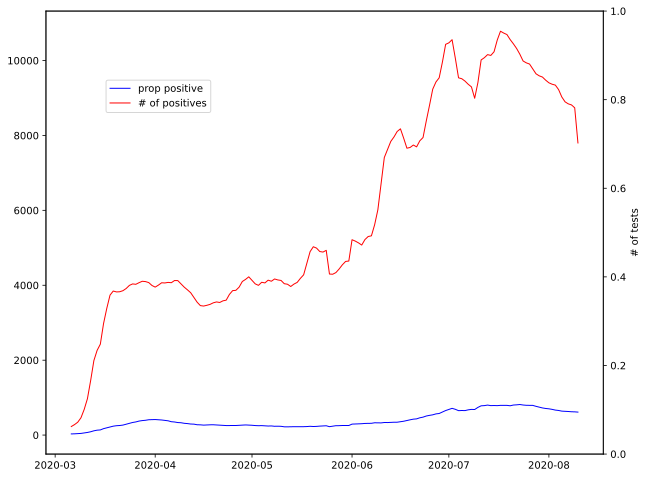

In [42]:
omit_from_end = 9
data = df.perc_pos.rolling(7).mean()[:-omit_from_end]
pos = df.pos.rolling(7).mean()[:-omit_from_end]
total = df.pos.rolling(7).mean() + df.neg.rolling(7).mean()[:-omit_from_end]

with plt.style.context('default'):
    plt.rcParams['figure.figsize'] = 10, 8
    fig, ax_1 = plt.subplots()
    
    line_1 = ax_1.plot(pos, linewidth=lw, color='blue', label='prop positive')
#     ax_2.set_ylabel('# of tests') 
    
    ax_2 = ax_1.twinx()
    line_2 = ax_1.plot(total, linewidth=lw, color='red', label='# of positives')
    ax_2.set_ylabel('# of tests')
    
    fig.legend(bbox_to_anchor=(0.3, 0.7))

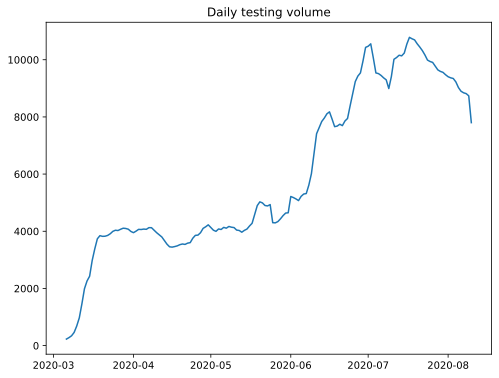

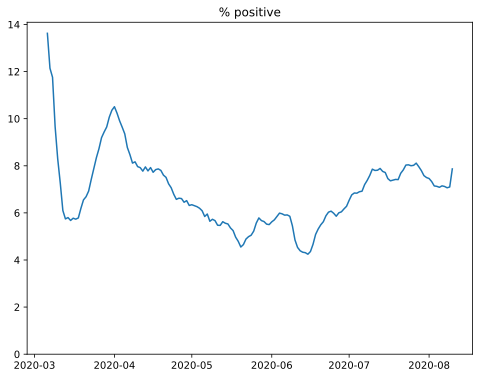

In [50]:
with plt.style.context('default'):
    plt.rcParams['figure.figsize'] = 8, 6
    plt.plot(total)
    plt.title('Daily testing volume')
    plt.show()
    
    plt.plot(pos / total * 100)
    plt.ylim([0, None])
    plt.title('% positive')
    plt.show()